In [39]:
from load_modules import *
from tensorflow.keras.layers import LeakyReLU
import my_config
import math
import importlib

from Landmark import gmm_specular, gmm_shadow, preprocess, plotting



In [40]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        print("Device:", device)
else:
    print("No GPU devices found.")

# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
    except RuntimeError as e:
        print(e)

# Test for GPU device name
name = tf.test.gpu_device_name()
if name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(name))

# Print the number of available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found GPU at: /device:GPU:0
Num GPUs Available:  1


Load LUT data and find duplicates, select one of each set where the likeleyhood of the parameter values is the greatest

In [41]:
upper_bounds = [0.99, 0.99, 0.99, 0.99, 0.25]
lower_bounds = [0.01, 0.001, 0.01, 0.6, 0.05]

# Pair up the corresponding bounds and calculate their average
averages = [(u + l) / 2 for u, l in zip(upper_bounds, lower_bounds)]
avg_Cm, avg_Ch, avg_Bm, avg_Bh, avg_T = averages

headers = "Cm,Ch,Bm,Bh,T,sR,sG,sB"
lut_path = r"C:\joel_cpp\FullMonte\FullMonte\lut_rgb.csv"

df = pd.read_csv(lut_path, names=headers.split(","), header=None)
#remove row 0
df = df.iloc[1:]
print(df.head())

#print length of df
print(len(df))
# convert all columns to float
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

#convert sR, sG, sB to int
rounded_df = df.round({'sR': 0, 'sG': 0, 'sB': 0})
# Step 1: Find duplicate RGB values
duplicates = rounded_df[rounded_df.duplicated(subset=['sR', 'sG', 'sB'], keep=False)].copy() # added .copy()
#print all duplicates
print(duplicates.head())

# Step 2: Calculate the 'likelihood' score for each row
duplicates['likelihood'] = (abs(duplicates['Cm'] - avg_Cm) +
                            abs(duplicates['Ch'] - avg_Ch) +
                            abs(duplicates['Bm'] - avg_Bm) +
                            abs(duplicates['Bh'] - avg_Bh) +
                            abs(duplicates['T'] - avg_T))

# Step 3: Sort by RGB values and likelihood, keeping the row with the lowest likelihood for each RGB group
most_likely_duplicates = duplicates.sort_values(['sR', 'sG', 'sB', 'likelihood']).drop_duplicates(subset=['sR', 'sG', 'sB'])

# Now, most_likely_duplicates should contain your desired rows

# First, remove all duplicates from the original dataframe
df_no_duplicates = df.drop_duplicates(subset=['sR', 'sG', 'sB'], keep=False)

# Concatenate df_no_duplicates with most_likely_duplicates to get the final dataframe
df = pd.concat([df_no_duplicates, most_likely_duplicates])

# If you want to sort it based on index
df.sort_index(inplace=True)
df.head()
#remove duplicates

x = df[['sR', 'sG', 'sB']].to_numpy(dtype='float32')
y = df[['Cm', 'Ch', 'Bm', 'Bh', 'T']].to_numpy(dtype='float32')
#create new csv with headers
# df.to_csv(r'LUTs\large_no_duplicates.csv', index=False, header=True)


#train nn on x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
#remove any header values
x_train = x_train[1:]
x_test = x_test[1:]
y_train = y_train[1:]
y_test = y_test[1:]

#numpy arrays
x_train = np.asarray(x_train).reshape(-1,3).astype('float32')
x_test = np.asarray(x_test).reshape(-1,3).astype('float32')
print(f"length of df {len(df)}")
print(f"bef norm x_train[0] {x_train[0]}")

#normalize
x_train = x_train/255.0
x_test = x_test/255.0
print(f"aft norm x_train[0] {x_train[0]}")

print(f"length of x_train {len(x_train)}")
print(f"length of x_test {len(x_test)}")
print(f"length of y_train {len(y_train)}")
print(f"length of y_test {len(y_test)}")
df.head()
print(f"length of df {len(df)}")
#print random 3 rows
#print unique values of Cm,Ch,Bm,Bh,T
# print(f"unique Cm {df['Cm'].unique()}")
# print(f"unique Ch {df['Ch'].unique()}")
# print(f"unique Bm {df['Bm'].unique()}")
# print(f"unique Bh {df['Bh'].unique()}")
# print(f"unique T {df['T'].unique()}")
#as sorted lists
C_m = sorted(df['Cm'].unique())
C_h = sorted(df['Ch'].unique())
B_m = sorted(df['Bm'].unique())
B_h = sorted(df['Bh'].unique())
T = sorted(df['T'].unique())
print(f"Cm = {C_m}")
print(f"Ch = {C_h}")
print(f"Bm = {B_m}")
print(f"Bh = {B_h}")
print(f"T = {T}")
#min max for each
min_vals = [min(C_m), min(C_h), min(B_m), min(B_h), min(T)]
max_vals = [max(C_m), max(C_h), max(B_m), max(B_h), max(T)]
print(f"upper bounds = {max_vals}")
print(f"lower bounds = {min_vals}")
#integer arrays for sR,sG,sB 0 to 255
# Assuming df is your DataFrame and it has columns 'sR', 'sG', 'sB'
df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].astype(float)
df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].applymap(np.round)
# Add a 'count' column that counts the number of identical RGB values
df['count'] = df.groupby(['sR', 'sG', 'sB'])['sR'].transform('count')
print(f"number of repeated RGB values {len(df[df['count'] > 1])}")

C:\Users\joeli\AppData\Local\Temp\ipykernel_181784\1374123018.py:11: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(lut_path, names=headers.split(","), header=None)


      Cm          Ch Bm Bh          T       sR       sG       sB
1  0.001  0.00760226  0  0       0.01  250.284   202.53  164.882
2  0.001  0.00760226  0  0  0.0614286   251.51  203.617  172.458
3  0.001  0.00760226  0  0  0.0785714  251.799  204.666  173.484
4  0.001  0.00760226  0  0       0.13  252.674  206.214  177.338
5  0.001  0.00760226  0  0   0.164286  253.629  207.254  179.571
749460
      Cm        Ch   Bm   Bh         T     sR     sG     sB
2  0.001  0.007602  0.0  0.0  0.061429  252.0  204.0  172.0
3  0.001  0.007602  0.0  0.0  0.078571  252.0  205.0  173.0
4  0.001  0.007602  0.0  0.0  0.130000  253.0  206.0  177.0
5  0.001  0.007602  0.0  0.0  0.164286  254.0  207.0  180.0
6  0.001  0.007602  0.0  0.0  0.027143  251.0  203.0  168.0
length of df 876607
bef norm x_train[0] [182.601 129.028  78.215]
aft norm x_train[0] [0.71608233 0.5059922  0.30672547]
length of x_train 701284
length of x_test 175321
length of y_train 701284
length of y_test 175321
length of df 876607
Cm =

In [42]:
np.random.seed(7)
BATCH_SIZE = 4096*16
NUM_NEURONS = 75
NUM_LAYERS = 2
NUM_EPOCHS = 200
LR = 1e-4
MLR = 1e-6
about_string = f"batch_size_{BATCH_SIZE}_neurons_{NUM_NEURONS}_layers_{NUM_LAYERS}_epochs_{NUM_EPOCHS}_lr_{LR}_mlr_{MLR}_upper_bounds_{upper_bounds}_lower_bounds_{lower_bounds}"

def decoder():
    input = Input(shape=(5,), name="decoder_input")
    for i in range(NUM_LAYERS):
        if i == 0:
            x = Dense(NUM_NEURONS, activation='relu', name=f"decoder_dense_{i+1}")(input)
        else:
            x = Dense(NUM_NEURONS, activation='relu', name=f"decoder_dense_{i+1}")(x)
    out = Dense(3, name="encoder_output")(x)
    #leaky relu activation=LeakyReLU(alpha=0.3)
    model = Model(inputs=input, outputs=out, name='decoder')
    return model

def encoder():
    input = Input(shape=(3,),name="encoder_input")
    for i in range(NUM_LAYERS):
        if i == 0:
            x = Dense(NUM_NEURONS, activation='relu', name=f"encoder_dense_{i+1}")(input)
        else:
            x = Dense(NUM_NEURONS, activation='relu', name=f"encoder_dense_{i+1}")(x)
    out = Dense(5, name="decoder_output")(x)
    model = Model(inputs=input, outputs=out, name = 'encoder')
    return model
def autoencoder(encoder, decoder):
    input_end_to_end = Input(shape=(3,))
    l1 = encoder(input_end_to_end)
    l2 = decoder(l1)
    input_list = [encoder.input, decoder.input, input_end_to_end]
    output_list = [encoder.output, decoder.output, l2]
    model = Model(inputs=input_list, outputs=output_list, name = 'autoencoder')
    return model
encoder = encoder()
decoder = decoder()
autoencoder = autoencoder(encoder, decoder)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

def albedo_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    l2_norm = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    # upper_bounds = [1.0, 1.0, 1.0]
    # lower_bounds = [0.0, 0.0, 0.0]
    # upper_bound_mask = tf.math.greater(y_pred, upper_bounds)
    # lower_bound_mask = tf.math.less(y_pred, lower_bounds)
    # out_of_range_mask = tf.logical_or(lower_bound_mask, upper_bound_mask)
    # # Apply a penalty for out of range values)
    # out_of_range_penalty = tf.reduce_sum(tf.cast(out_of_range_mask, tf.float32))/BATCH_SIZE
    return  l1_norm

def parameter_loss(y_true, y_pred):
    #l2 norm
    l2_norm = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    return  l2_norm 
    
def end_to_end_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    # l2_norm = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    return l1_norm 

autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights=[.3,.1,.6])



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 3)]               0         
                                                                 
 encoder_dense_1 (Dense)     (None, 75)                300       
                                                                 
 encoder_dense_2 (Dense)     (None, 75)                5700      
                                                                 
 decoder_output (Dense)      (None, 5)                 380       
                                                                 
Total params: 6,380
Trainable params: 6,380
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None

In [ ]:
checkpoint = ModelCheckpoint(my_config.CHECKPOINT_PATH, monitor='loss', verbose=0,
    save_best_only=True, mode='auto', period=200)
adjust_lr = ReduceLROnPlateau(monitor='loss', factor=0.01, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=MLR, lr=LR)
# Define the Keras TensorBoard callback.

# tensorboard_callback = tf.keras.callbacks.TensorBoard(filepath=logdir, save_weights_only = True,save_freq = 100,verbose = 1)
print_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"epoch: {epoch} , {logs}") if epoch % 25 == 0 else None)

callbacks = [
    checkpoint,
    adjust_lr,
    print_callback
]
with tf.device('/device:GPU:0') as device:
    #show device name
    print(device)
    #ae_in: enc_in, dec_in, end_to_end_in
    x = [x_train, y_train,x_train]
     #ae_out: enc_out, dec_out, end_to_end_out
    x_val = [x_test, y_test,x_test]
    #outputs: encoder, decoder, autoencoder
    y = [y_train,x_train,x_train]
    y_val = [y_test,x_test,x_test]
    autoencoder.fit(x,y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val), callbacks=callbacks,verbose=0)

       

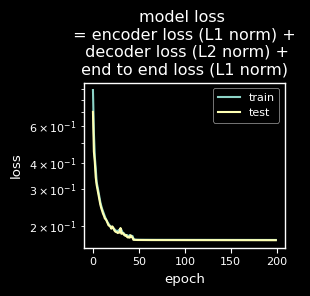

In [34]:
plt.style.use('dark_background')
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(3,3))
plt.plot(autoencoder.history.history['loss']) 
plt.plot(autoencoder.history.history['val_loss'])
plt.title('model loss \n = encoder loss (L1 norm) + \n decoder loss (L2 norm) +\n end to end loss (L1 norm) ')
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.yticks
# plt.xlim(-1,50)
plt.tight_layout()
plt.legend(['train', 'test'], loc='upper right')
#show tick labels
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.show()




In [26]:
def encode(image):
    print(f"Image shape at start of encoder method: {image.shape}")
    if len(image.shape) == 2:
        WIDTH = HEIGHT = int(math.sqrt(image.shape[0]))
        image = np.asarray(image).reshape(-1,4).astype('float32')
    else:
        WIDTH = image.shape[0]
        HEIGHT = image.shape[1]
        image = np.asarray(image).astype('float32')
    image = image.reshape(WIDTH*HEIGHT, 3) 
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        print(f"Image shape before encoder inference: {image.shape}")
        pred_maps = encoder.predict_on_batch(image)
    #reshape to 1
    end = time.time()
    elapsed = end - start
    #reshape to -1,3
    pred_maps = pred_maps.reshape(WIDTH*HEIGHT, 5)  # for RGB image
    return pred_maps, elapsed, (WIDTH, HEIGHT)
 
def decode(encoded):
    print(f"Image shape going into encoder: {encoded.shape}")
    start = time.time()
    #check if encoded is 2d or 3d
    if len(encoded.shape) == 2:
        WIDTH = HEIGHT = int(math.sqrt(encoded.shape[0]))
        encoded = np.asarray(encoded).reshape(-1,5).astype('float32')
    else:
        WIDTH = encoded.shape[0]
        HEIGHT = encoded.shape[1]
        encoded = np.asarray(encoded).astype('float32')
    with tf.device('/device:GPU:0') as device:
        #lower batch size to 2048
        print(f"encoded shape going into decoder: {encoded.shape}")
        recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    recovered = recovered.reshape(WIDTH, HEIGHT, 3)  # for RGB image
    return recovered, elapsed, (WIDTH, HEIGHT)

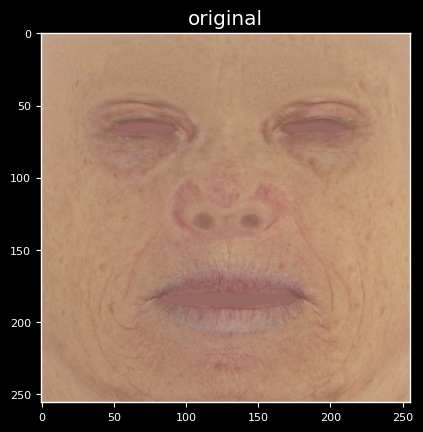

Image shape at start of encoder method: (256, 256, 3)
Image shape before encoder inference: (65536, 3)
CM 0.0 1.0
CH 0.0 1.0
BM 0.0 1.0
BH 0.0 1.0
T 0.0 1.0
encode time 0.025757789611816406
Image shape going into encoder: (65536, 5)
encoded shape going into decoder: (65536, 5)


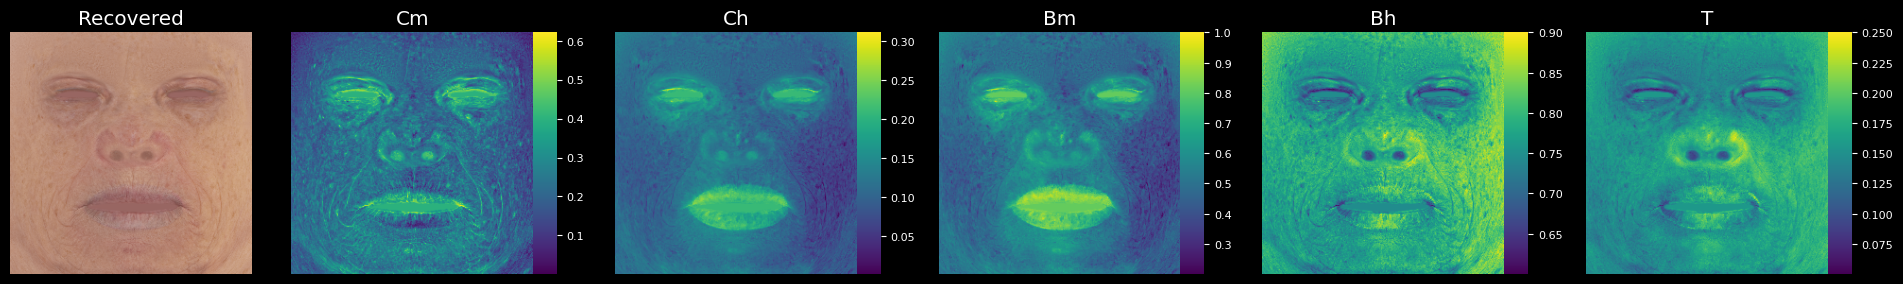

In [33]:
WIDTH = 256
HEIGHT = 256
importlib.reload(gmm_specular)
importlib.reload(gmm_shadow)
importlib.reload(preprocess)
importlib.reload(plotting)

#dark background style
plt.style.use('dark_background')
#grid off 
plt.rcParams['axes.grid'] = False
#reload
importlib.reload(gmm_specular)
importlib.reload(gmm_shadow)
# Load your image
image_rgb = cv2.imread( r"C:\Users\joeli\Dropbox\HM_Oct\models_4k\m32.png")
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)
image_rgb = preprocess.crop_face(image_rgb)[0]
image_rgb = cv2.resize(image_rgb, (WIDTH, HEIGHT))
#numpy array
image_rgb = np.asarray(image_rgb).astype('float32')/255.0
plt.imshow(image_rgb)
plt.title("original")
plt.show()
parameter_maps, elapsed, d1 = encode(image_rgb)
pm1 = parameter_maps.copy().reshape(d1[0], d1[1], 5)
#normalize
Cm = parameter_maps[:,0]
Ch = parameter_maps[:,1]
Bm = parameter_maps[:,2]
Bh = parameter_maps[:,3]
T = parameter_maps[:,4]
#normalize
Cm = (Cm - np.min(Cm))/(np.max(Cm) - np.min(Cm))
Ch = (Ch - np.min(Ch))/(np.max(Ch) - np.min(Ch))
Bm = (Bm - np.min(Bm))/(np.max(Bm) - np.min(Bm))
Bh = (Bh - np.min(Bh))/(np.max(Bh) - np.min(Bh))
T = (T - np.min(T))/(np.max(T) - np.min(T))
parameter_maps[:,0] = Cm*0.62+0.001
parameter_maps[:,1] = Ch*0.31+0.001
parameter_maps[:,2] = Bm*0.8+0.2
parameter_maps[:,3] = Bh*0.3+0.6
parameter_maps[:,4] = T*0.2+0.05
print(f"CM {Cm.min()} {Cm.max()}")
print(f"CH {Ch.min()} {Ch.max()}")
print(f"BM {Bm.min()} {Bm.max()}")
print(f"BH {Bh.min()} {Bh.max()}")
print(f"T {T.min()} {T.max()}")
WIDTH, HEIGHT = d1
print(f"encode time {elapsed}")

recovered,elapsed, d2 = decode(pm1.reshape(-1,5))
# recovered = cv2.cvtColor(recovered, cv2.COLOR_BGR2RGB)

WIDTH, HEIGHT = d2
recovered = recovered

plotting.PLOT_TEX_MAPS(recovered, parameter_maps)